# Read all ensemble members

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/datadrive/data/')
olddata_dir  = Path('/datadrive/olddata/')

assert data_dir.exists()
assert olddata_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
import sys
sys.version

'3.8.10 (default, May 19 2021, 18:05:58) \n[GCC 7.3.0]'

In [7]:
# read in the training data
ds = xr.open_dataset(olddata_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(olddata_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Geospatial help

In [8]:
import geopandas as gpd
from typing import Any, Optional, Dict, List, Tuple


d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
points.name = "geometry"
world = gpd.read_file(olddata_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")

In [9]:
def create_geospatial_data(df: pd.DataFrame) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(df.join(points), crs="epsg:4326")


def _plot_geospatial(metric_data: gpd.GeoDataFrame, column: str, ax: Any, legend: bool = True, cax: Optional[Any] = None, kwargs: Dict = {}):
    # plot the chloropleth
    metric_data.to_crs(epsg=4326).plot(column, ax=ax, cax=cax, legend=legend, **kwargs);

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)

    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])
    ax.axis('off')
    return ax

# Read ensemble members

In [10]:
from scripts.drafts.io_results import read_ensemble_member_results

In [11]:
run_dir = olddata_dir / "runs/ensemble_lstm_TEMP"
ensemble_fp = run_dir / "ensemble_all.nc"
assert ensemble_fp.exists()
ensemble_ds = xr.open_dataset(ensemble_fp)

In [12]:
ensemble_ds

<xarray.Dataset>
Dimensions:     (member: 9, station_id: 669, time: 4018)
Coordinates:
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
  * member      (member) object 'mean' 'ensemble6' ... 'ensemble2' 'ensemble8'
Data variables:
    obs         (member, station_id, time) float32 ...
    sim         (member, station_id, time) float32 ...

In [13]:
ealstm_run_dir = olddata_dir / "runs/ensemble_ealstm_TEMP"
ealstm_ensemble_fp = ealstm_run_dir / "ensemble_all.nc"

ealstm_ensemble_ds = xr.open_dataset(ealstm_ensemble_fp)

# Calculate the errors

In [14]:
def _member_dimension_to_variable(ensemble_ds: xr.Dataset):
    assert "member" in ensemble_ds.coords
    member_ds = []
    for i, member in enumerate(ensemble_ds.member):
        temp_ = ensemble_ds.sel(member=member).rename({"sim": str(member.values)}).drop("member")

        if i != 0:
            temp_.drop("obs")
        member_ds.append(temp_)

    return xr.merge(member_ds)


ensemble_preds = _member_dimension_to_variable(ensemble_ds)
ealstm_ensemble_preds = _member_dimension_to_variable(ealstm_ensemble_ds)

In [15]:
# invert back to defaultdict
from collections import defaultdict
from typing import DefaultDict


def create_default_dict_from_xarray_object_of_errors(all_errors: xr.Dataset) -> DefaultDict:
    ensemble_errors = defaultdict(dict)
    for member in all_errors.member.values:
        error_df = all_errors.sel(member=member).drop("member").to_dataframe()
        ensemble_errors[member] = error_df

    return ensemble_errors


def get_errors(ensemble_preds: xr.Dataset, run_dir: Path) -> Tuple[xr.Dataset, DefaultDict[str, Dict[str, pd.DataFrame]]]:
    if not (run_dir / "all_errors.nc").exists():
        ensemble_errors = calculate_all_data_errors(ensemble_preds, decompose_kge=True, yilmaz_errors=True)
    
        # create one big Dataset
        all_errors = []
        members = [member for member in ensemble_errors.keys()]
        for member in members:
            # pd.DataFrame
            ensemble_errors[member]["member"] = member
            # xr.Dataset
            all_errors.append(ensemble_errors[member].reset_index().set_index(["member", "station_id"]).to_xarray())

        all_errors = xr.concat(all_errors, dim="member")
        all_errors.to_netcdf(run_dir / "all_errors.nc")
    
    else:
        all_errors = xr.open_dataset(run_dir / "all_errors.nc")
        ensemble_errors = create_default_dict_from_xarray_object_of_errors(all_errors)
        
    return all_errors, ensemble_errors

In [16]:
# run_dir

In [17]:
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict

all_errors, ensemble_errors = get_errors(ensemble_preds, run_dir)
ealstm_all_errors, ealstm_ensemble_errors = get_errors(ealstm_ensemble_preds, run_dir=olddata_dir / "runs/ensemble_ealstm_TEMP")

In [18]:
# display(ealstm_ensemble_preds["mean"].sel(time="2007", station_id=10002).values[:10])
# display(ensemble_preds["mean"].sel(time="2007", station_id=10002).values[:10])

# display(all_errors.sel(member="mean", station_id=10002)["nse"])
# display(ealstm_all_errors.sel(member="mean", station_id=10002)["nse"])

In [19]:
lstm_ens_errors = all_errors.sel(member=[m for m in all_errors.member.values if "mean" not in m])
ealstm_ens_errors = ealstm_all_errors.sel(member=[m for m in ealstm_all_errors.member.values if "mean" not in m])

In [20]:
from scipy.stats import iqr
metrics = ["nse", "bias_error", "std_error", "correlation", "fms", "flv", "fhv"]
IQR = False
if IQR:
    print(lstm_ens_errors.to_dataframe().apply(iqr)[metrics].to_latex(float_format="%.2f"))
    print(ealstm_ens_errors.to_dataframe().apply(iqr)[metrics].to_latex(float_format="%.2f"))
else:
    print(lstm_ens_errors.to_dataframe().std()[metrics].to_latex(float_format="%.2f"))
    print(ealstm_ens_errors.to_dataframe().std()[metrics].to_latex(float_format="%.2f"))

\begin{tabular}{lr}
\toprule
{} &              0 \\
\midrule
nse         &           0.10 \\
bias\_error  &           0.10 \\
std\_error   &           0.11 \\
correlation &           0.04 \\
fms         &          14.68 \\
flv         & 45297197766.08 \\
fhv         &          11.13 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &              0 \\
\midrule
nse         &           0.14 \\
bias\_error  &           0.12 \\
std\_error   &           0.13 \\
correlation &           0.04 \\
fms         &          17.01 \\
flv         & 62765153029.57 \\
fhv         &          14.19 \\
\bottomrule
\end{tabular}



In [21]:
from typing import DefaultDict
from collections import defaultdict


def invert_errors_dict(all_errors: DefaultDict) -> DefaultDict:
    model = [k for k in ensemble_errors.keys()][0]
    metrics = ensemble_errors[model].columns
    all_metrics_list = defaultdict(list)
    for model in ensemble_errors.keys():
        for metric in metrics:
            all_metrics_list[metric].append(ensemble_errors[model][metric].rename(model))

    all_metrics = defaultdict()
    for metric in all_metrics_list.keys():
        df = pd.concat(all_metrics_list[metric], axis=1)
        all_metrics[metric] = df

    return all_metrics
    

all_metrics = invert_errors_dict(ensemble_errors)
ealstm_all_metrics = invert_errors_dict(ealstm_ensemble_errors)

In [22]:
# lstm_nse = all_metrics["nse"].drop("mean", axis=1).to_xarray()
# ealstm_nse = ealstm_all_metrics["nse"].drop("mean", axis=1).to_xarray()

# What are the Variabilities in Metrics?

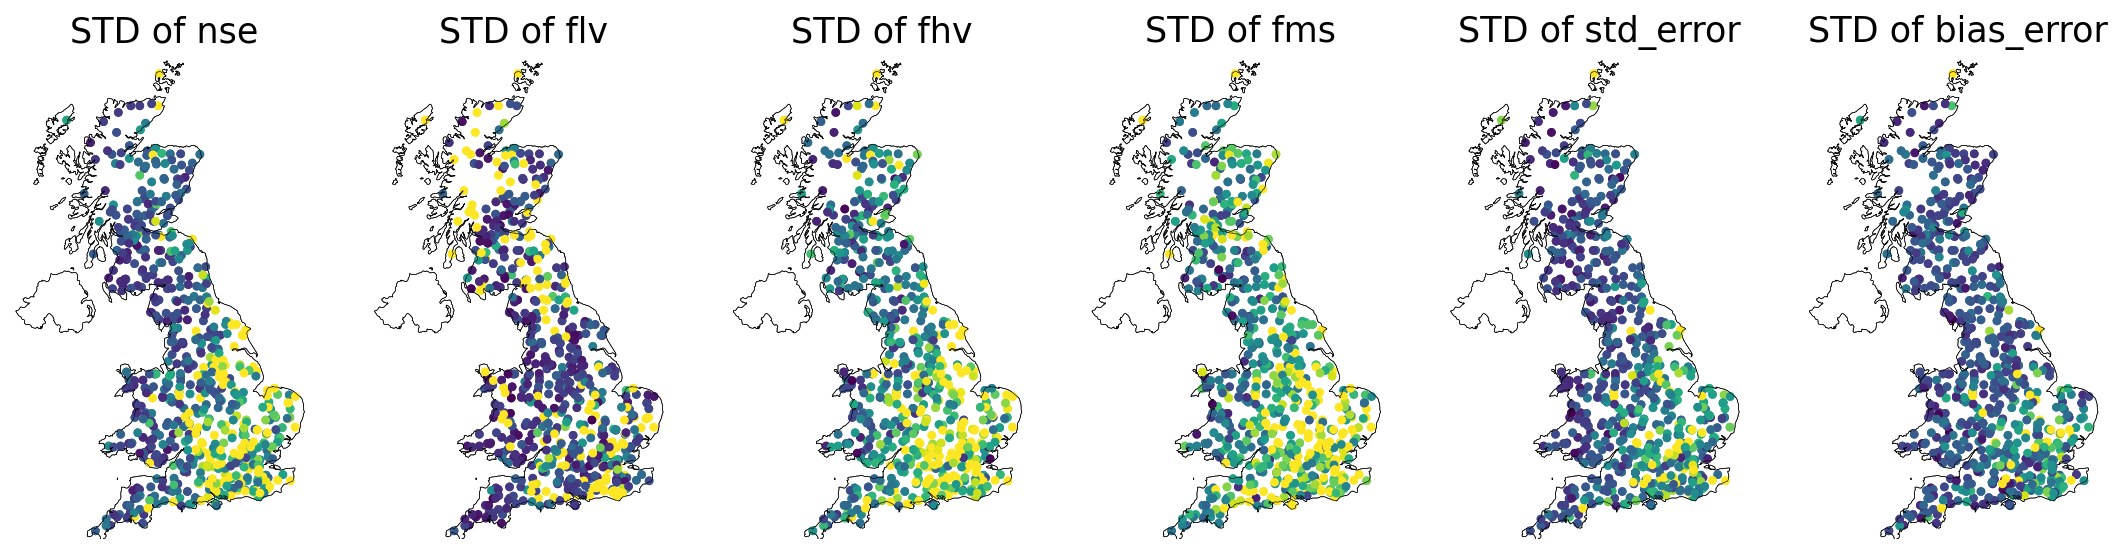

In [23]:
scale = 0.6
markersize = 10
fig, axs = plt.subplots(1, 6, figsize=(5*scale*6, 8*scale*1))

lookup = {
    "nse":{"vmin": 0.0, "vmax": 0.025,  "markersize": markersize},
    "flv":{"vmin": None, "vmax": 100,  "markersize": markersize},
    "fhv":{"vmin": None, "vmax": 5,  "markersize": markersize},
    "fms":{"vmin": None, "vmax": 8,  "markersize": markersize},
    "std_error":{"vmin": None, "vmax": 0.08,  "markersize": markersize},
    "bias_error":{"vmin": None, "vmax": 0.08,  "markersize": markersize},
    "":{"vmin": None, "vmax": None,  "markersize": markersize},
}

for ix, metric in enumerate(['nse', 'flv', 'fhv', 'fms', 'std_error', 'bias_error']):
    ax = axs[ix]
    _plot_geospatial(
        create_geospatial_data(
            all_metrics[metric].drop("mean", axis=1).std(axis=1).to_frame(name=metric)
        ),
        column=metric,
        ax=ax,
        kwargs=lookup[metric],
        legend=False
    );
    ax.set_title(f"STD of {metric}")
    

for ix, metric in enumerate(['nse', 'flv', 'fhv', 'fms', 'std_error', 'bias_error']):
    ax = axs[ix]
    _plot_geospatial(
        create_geospatial_data(
            ealstm_all_metrics[metric].drop("mean", axis=1).std(axis=1).to_frame(name=metric)
        ),
        column=metric,
        ax=ax,
        kwargs=lookup[metric],
        legend=False
    );
    ax.set_title(f"STD of {metric}")

In [24]:
from scripts.drafts.plots import plot_cdf
scale = 0.6
FIGSIZE = (12*scale, 8*scale)

clipping_lookup = {
    "nse": (0, 1.),
    "kge": (0, 1),
    "correlation": (0.5, 1),
    "bias_ratio": (0, 1.5),
    "variability_ratio": (0, 1.5),
    "bias_error": (-0.5, 0.5),
    "std_error": (-0.5, 0.5),
    "bias_error_pct": (-50, 50),
    "std_error_pct": (-50, 50),
    "flv": (-100, 100), 
    "fms": (-100, 100), 
    "fhv": (-100, 100), 
}

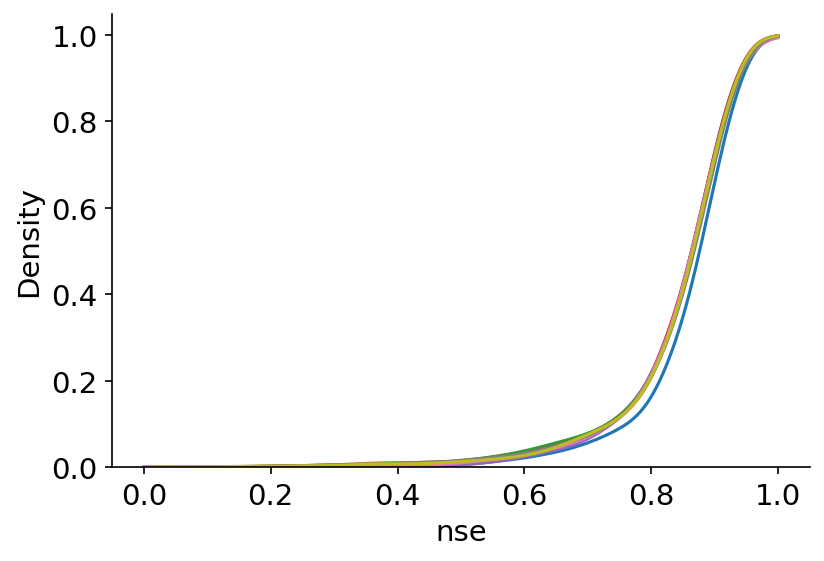

In [25]:
f, ax = plt.subplots()
metric = "nse"
all_metrics[metric]

for col in all_metrics[metric].columns:
    data = all_metrics[metric][col]
    sns.distplot(all_metrics[metric][col], hist=False, kde_kws=dict(cumulative=True, clip=(0, 1)), label=col, ax=ax)
#     n, bins, patches = ax.hist(, bins=100, density=True, histtype='step', cumulative=True, label='Empirical')

ax.set_xlabel(metric)
sns.despine()

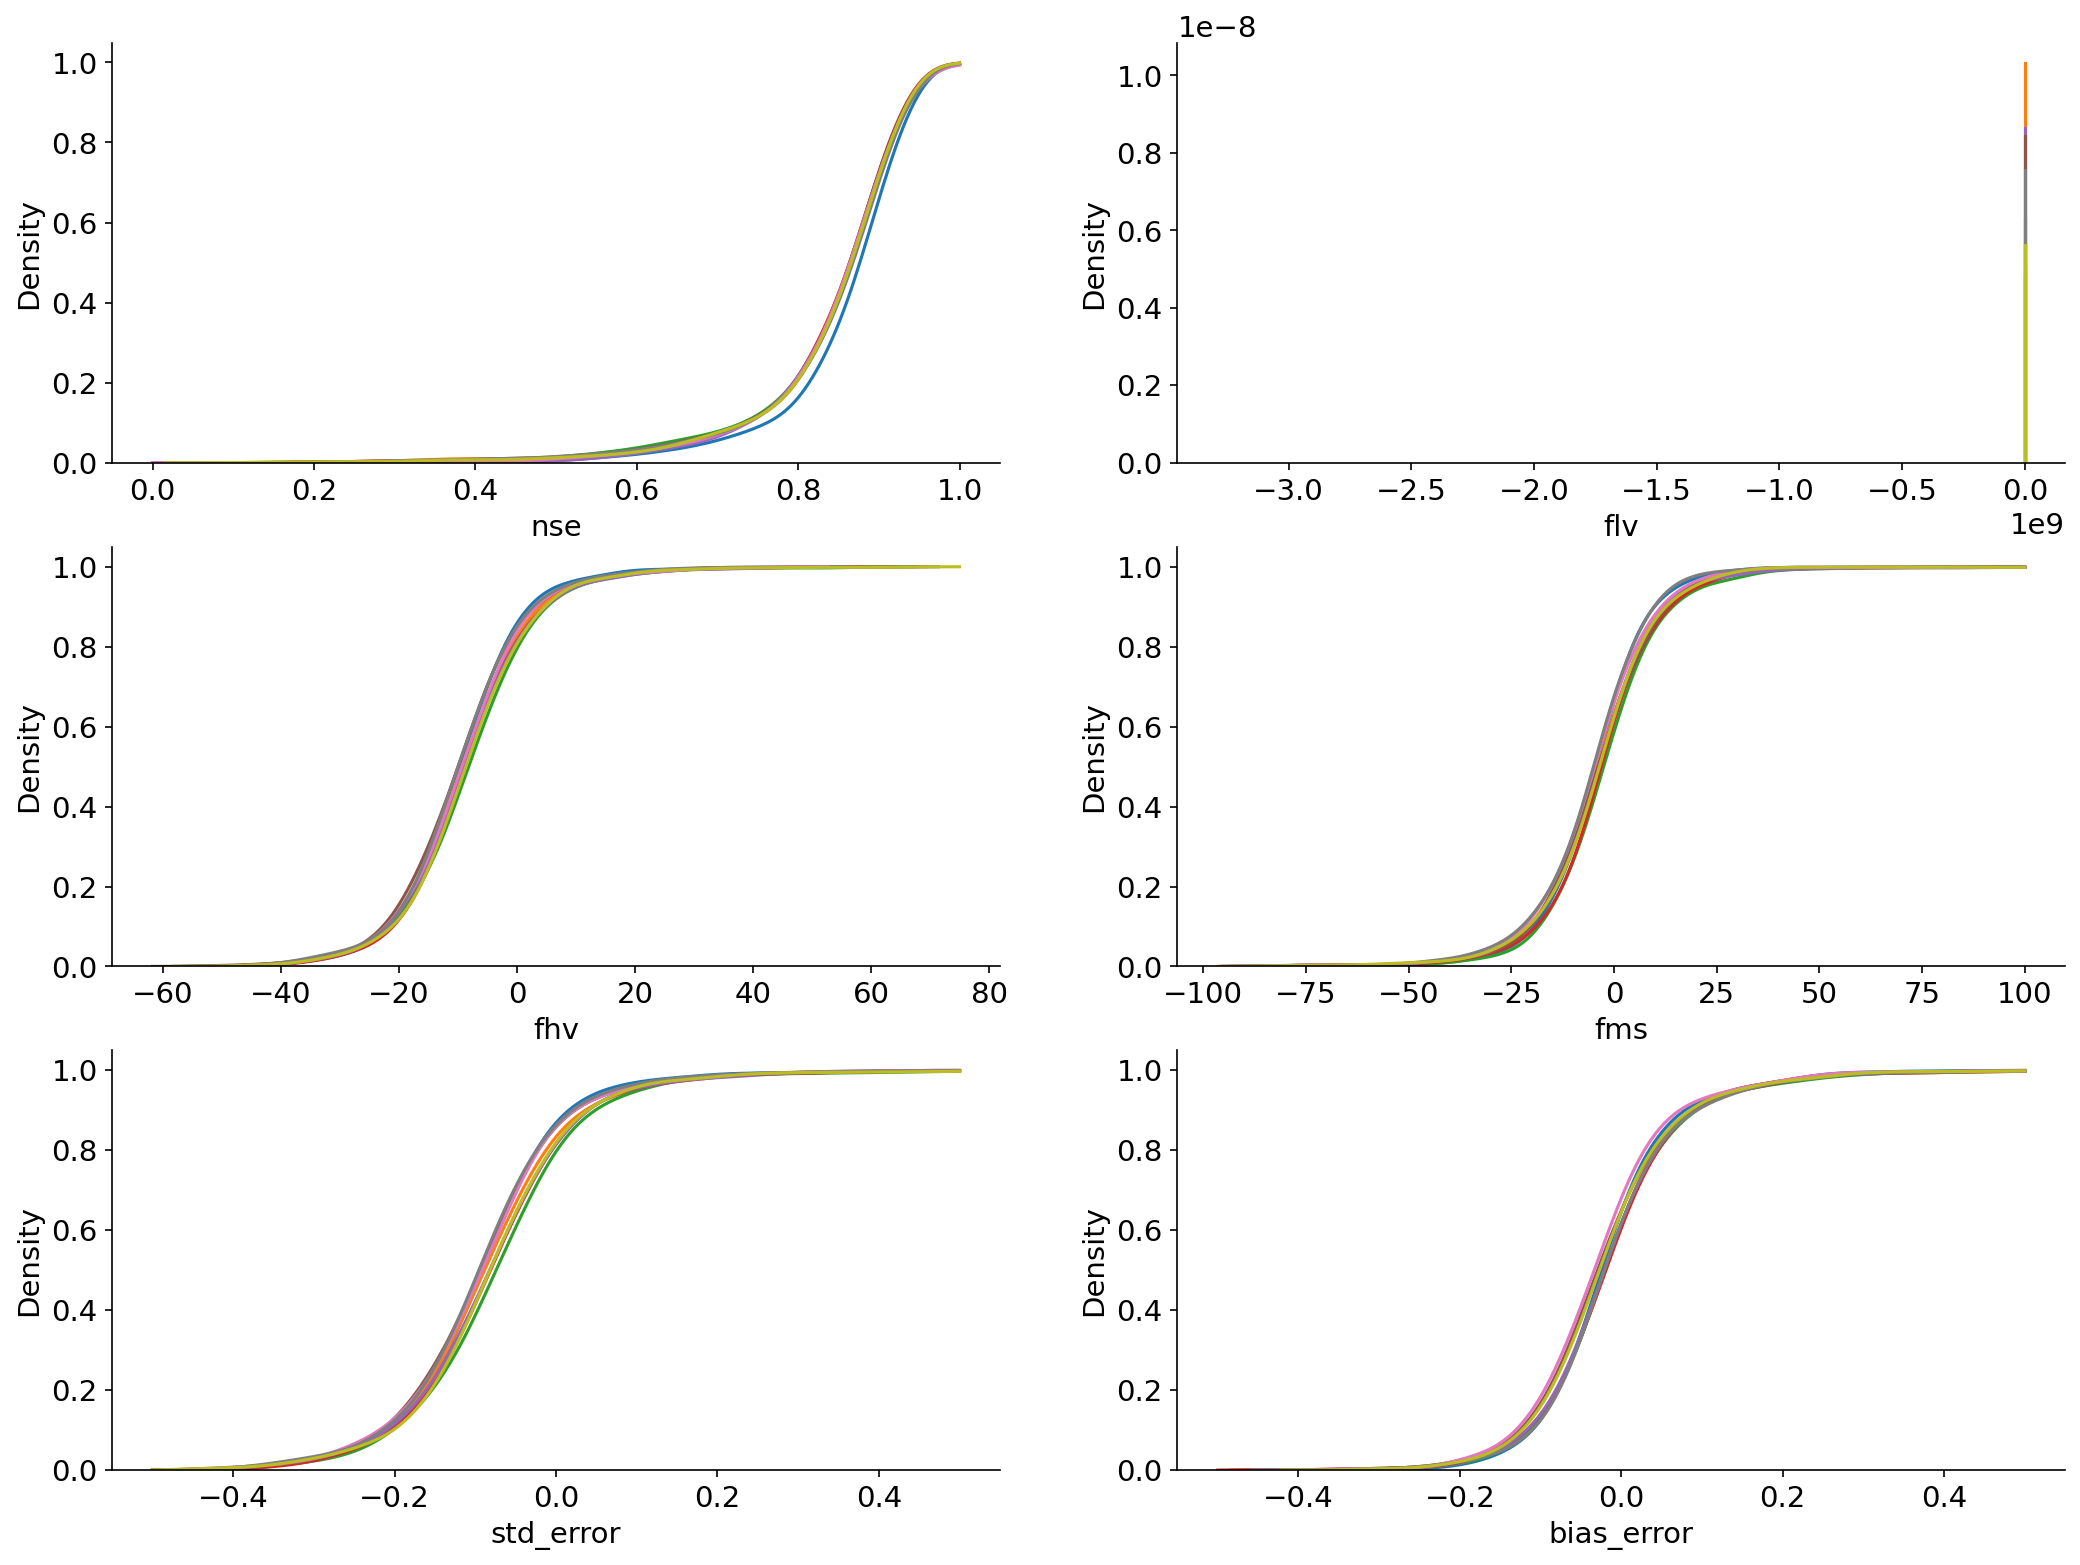

In [26]:
metric = "nse"
scale = 0.7
f, axs = plt.subplots(3, 2, figsize=(12*scale*2, 6*scale*3))

for ix, metric in enumerate(['nse', 'flv', 'fhv', 'fms', 'std_error', 'bias_error']):
    ax = axs[np.unravel_index(ix, (3, 2))]
    metric_data = all_metrics[metric]
    for col in all_metrics[metric].columns:
        sns.distplot(all_metrics[metric][col], hist=False, kde_kws=dict(cumulative=True, clip=clipping_lookup[metric]), label=col, ax=ax)
    ax.set_xlabel(metric)
#     ax.get_legend().remove()

    sns.despine()

# Calculate basic uncertainties

In [27]:
# mad = (ensemble_ds.drop("obs") - ensemble_ds.drop("obs").median(dim=["member"])).median(dim=["member", "time"]).to_dataframe()

In [28]:
# (ensemble_ds.drop("obs") - ensemble_ds.drop("obs").median(dim=["member", "time"])).median(dim=["member", "time"]).to_dataframe()

In [29]:
# normalise the variability of prediction by the mean discharge
std_norm_q = (ensemble_ds.drop("obs").std(dim=["member", "time"]) / static.q_mean).to_dataframe()

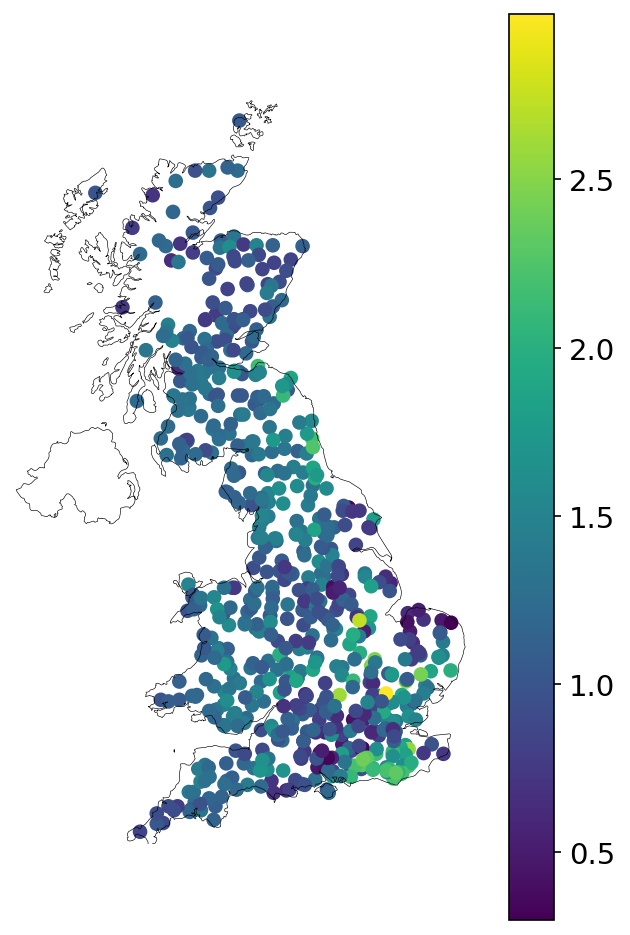

In [30]:
fig, ax = plt.subplots(figsize=(5, 8))

_plot_geospatial(
    create_geospatial_data(std_norm_q),
    column="sim",
    ax=ax
);

# Correlations of variability with static features

In [31]:
from scipy.stats import spearmanr, kendalltau

def calculate_correlation_with_static_features(metric_values: pd.Series, static_df: pd.DataFrame, method: str = "spearman") -> pd.DataFrame:
    func_lookup = {
        "kendall": kendalltau,
        "spearman": spearmanr,
    }
    out = defaultdict(list)
    
    static_df = static_df.loc[metric_values.index]
    assert all(static_df.index == metric_values.index)
    
    for feature in static_df.columns:
        result = func_lookup[method](metric_values, static_df[feature])
        out["correlation"].append(result.correlation)
        out["pvalue"].append(result.pvalue)
        out["variable"].append(feature)

    rank_correlations = pd.DataFrame(out)
    return rank_correlations

### How to calculate the uncertainty in the spread (variability of predicted discharge?)

In [32]:
# std_norm_q = (ensemble_ds.drop("obs").std(dim=["member", "time"]) / static.q_mean).to_dataframe()
std_norm_q = (ensemble_ds.drop("obs").std(dim="member")/ static.q_mean).mean(dim="time") .to_dataframe()
# ealstm_std_norm_q = (ealstm_ensemble_ds.drop("obs").std(dim=["member", "time"]) / static.q_mean).to_dataframe()
ealstm_std_norm_q = (ensemble_ds.drop("obs").std(dim="member") / static.q_mean).mean(dim="time").to_dataframe()


# annoying cell

<AxesSubplot:title={'center':'EALSTM'}>

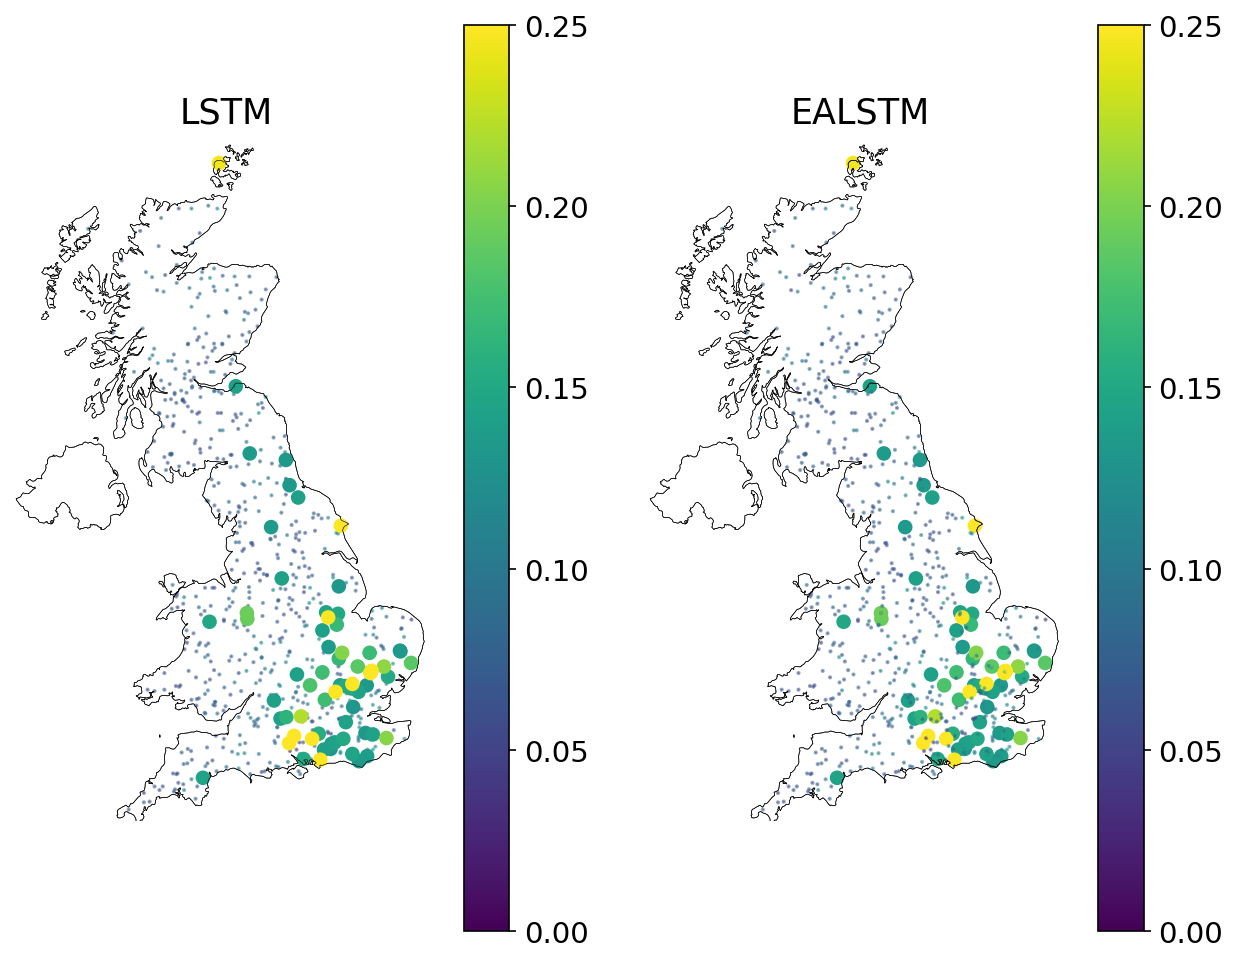

In [33]:
# Top 10% catchments with highest variability
f, axs = plt.subplots(1,2, figsize=(5*2, 8))
# lstm
ax = axs[0]
top_10 = std_norm_q.sort_values(by="sim")[-(len(std_norm_q) // 10):]
ax.set_title("LSTM")
_plot_geospatial(
    create_geospatial_data(std_norm_q),
    column="sim",
    ax=ax,
    kwargs=dict(cmap="viridis", vmin=0, vmax=0.25, markersize=1, alpha=0.5)
)
_plot_geospatial(
    create_geospatial_data(top_10),
    column="sim",
    ax=ax,
    legend=False,
    kwargs=dict(cmap="viridis", vmin=0, vmax=0.25)
)


ax = axs[1]
top_10 = ealstm_std_norm_q.sort_values(by="sim")[-(len(ealstm_std_norm_q) // 10):]
ax.set_title("EALSTM")
_plot_geospatial(
    create_geospatial_data(top_10),
    column="sim",
    ax=ax,
    kwargs=dict(cmap="viridis", vmin=0, vmax=0.25)
)
_plot_geospatial(
    create_geospatial_data(ealstm_std_norm_q),
    column="sim",
    ax=ax,
    legend=False,
    kwargs=dict(cmap="viridis", vmin=0, vmax=0.25, markersize=1, alpha=0.5)
)


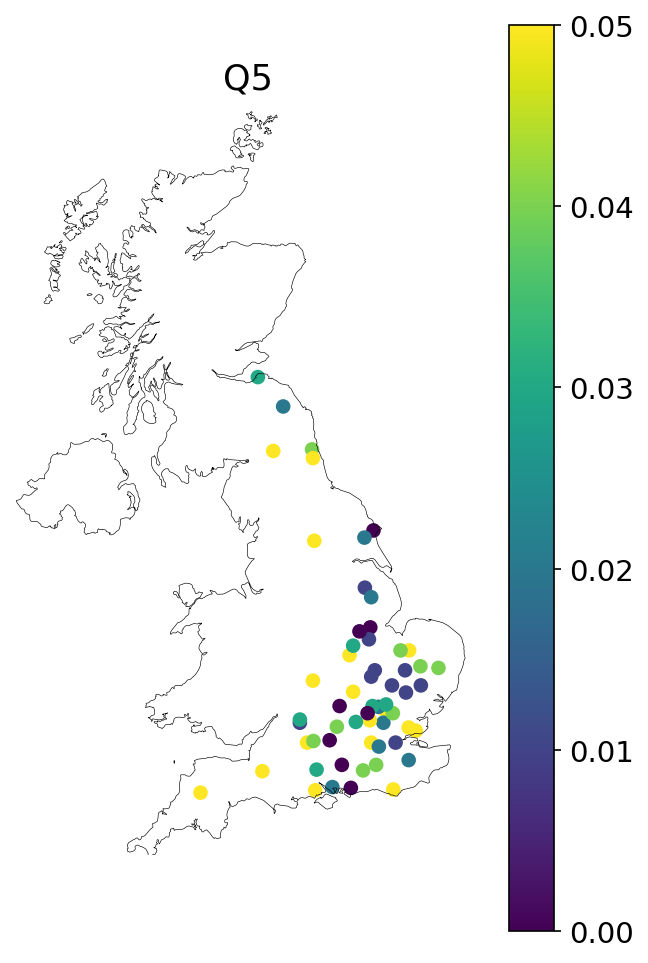

In [34]:
variable = "Q5"
vals = static.sel(station_id=static[variable] < static[variable].quantile(q=0.1))

fig, ax = plt.subplots(figsize=(5, 8))
_plot_geospatial(
    create_geospatial_data(vals[variable].to_dataframe()),
    column=variable,
    ax=ax
)
ax.set_title(variable);

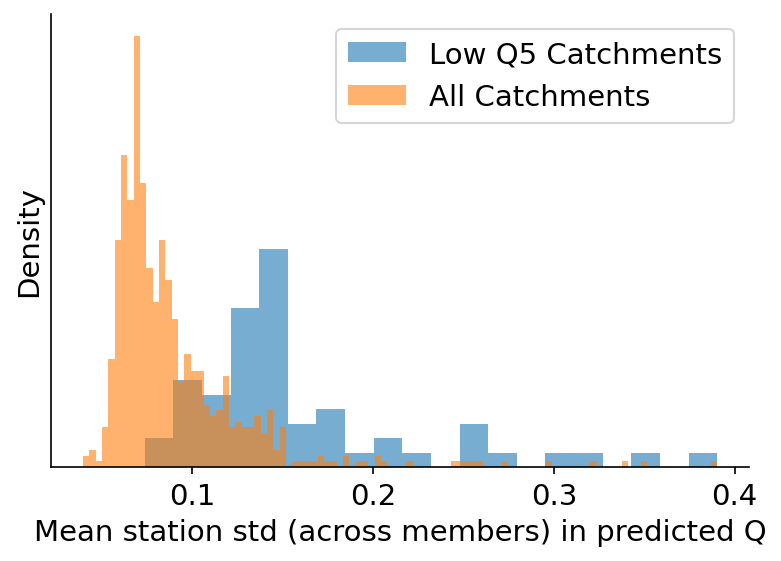

In [35]:
_sids = vals.station_id.values
_sids = ealstm_std_norm_q.index[np.isin(ealstm_std_norm_q.index, _sids)]

plt.hist(ealstm_std_norm_q.loc[_sids], bins=20, alpha=0.6, density=True, label=f"Low {variable} Catchments");
# .loc[~np.isin(ealstm_std_norm_q.index, bf_sids)]
plt.hist(ealstm_std_norm_q, bins=100, alpha=0.6, density=True, label="All Catchments");

ax = plt.gca()
ax.set_xlabel("Mean station std (across members) in predicted Q")
ax.set_ylabel("Density")
ax.set_yticklabels([])
ax.set_yticks([])
plt.legend()
sns.despine()

In [36]:
from scripts.static_correlations import (
    calculate_correlations,
    calculate_multi_model_correlations,
    
)

In [37]:
important_features = [
    # topography
    "dpsbar",
    "elev_mean",
    "elev_min",
    "elev_max",
    # Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "slope_fdc",
    "baseflow_index",
    "Q5",
    "Q95",
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    # landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
]


metric = "correlation"

## Calculate correlations 
# for variance_metric
corr_df = calculate_correlation_with_static_features(std_norm_q, static[important_features].to_dataframe(), method="spearman")
corr_df["model"] = "LSTM"
_corr_df = calculate_correlation_with_static_features(ealstm_std_norm_q, static[important_features].to_dataframe(), method="spearman")
_corr_df["model"] = "EALSTM"

corr_df = pd.concat([corr_df,_corr_df])

## Assign the extra columns (for the plotter below)
corr_df["significant"] = corr_df["pvalue"] < 0.001
corr_df["positive"] = corr_df["correlation"] > 0

# Sort Model columns for plotting
model_sorter = ["LSTM", "EALSTM"] # , "TOPMODEL", "SACRAMENTO", "ARNOVIC", "PRMS"]
variable_sorter = important_features

corr_df["model"] = corr_df["model"].astype("category")
corr_df["model"].cat.set_categories(model_sorter, inplace=True)

# Sort Variable columns for plotting
corr_df["variable"] = corr_df["variable"].astype("category")
corr_df["variable"].cat.set_categories(variable_sorter, inplace=True)
corr_df = corr_df.sort_values(["model", "variable"])

corr_df.head()
corr_df.tail()

,correlation,pvalue,variable,model,significant,positive
15,-0.366300,1.134095e-22,ewood_perc,EALSTM,True,False
16,-0.341177,1.066429e-19,grass_perc,EALSTM,True,False
17,-0.404337,1.056997e-27,shrub_perc,EALSTM,True,False
18,0.323676,8.810878e-18,crop_perc,EALSTM,True,True
19,0.094810,1.415915e-02,urban_perc,EALSTM,False,True


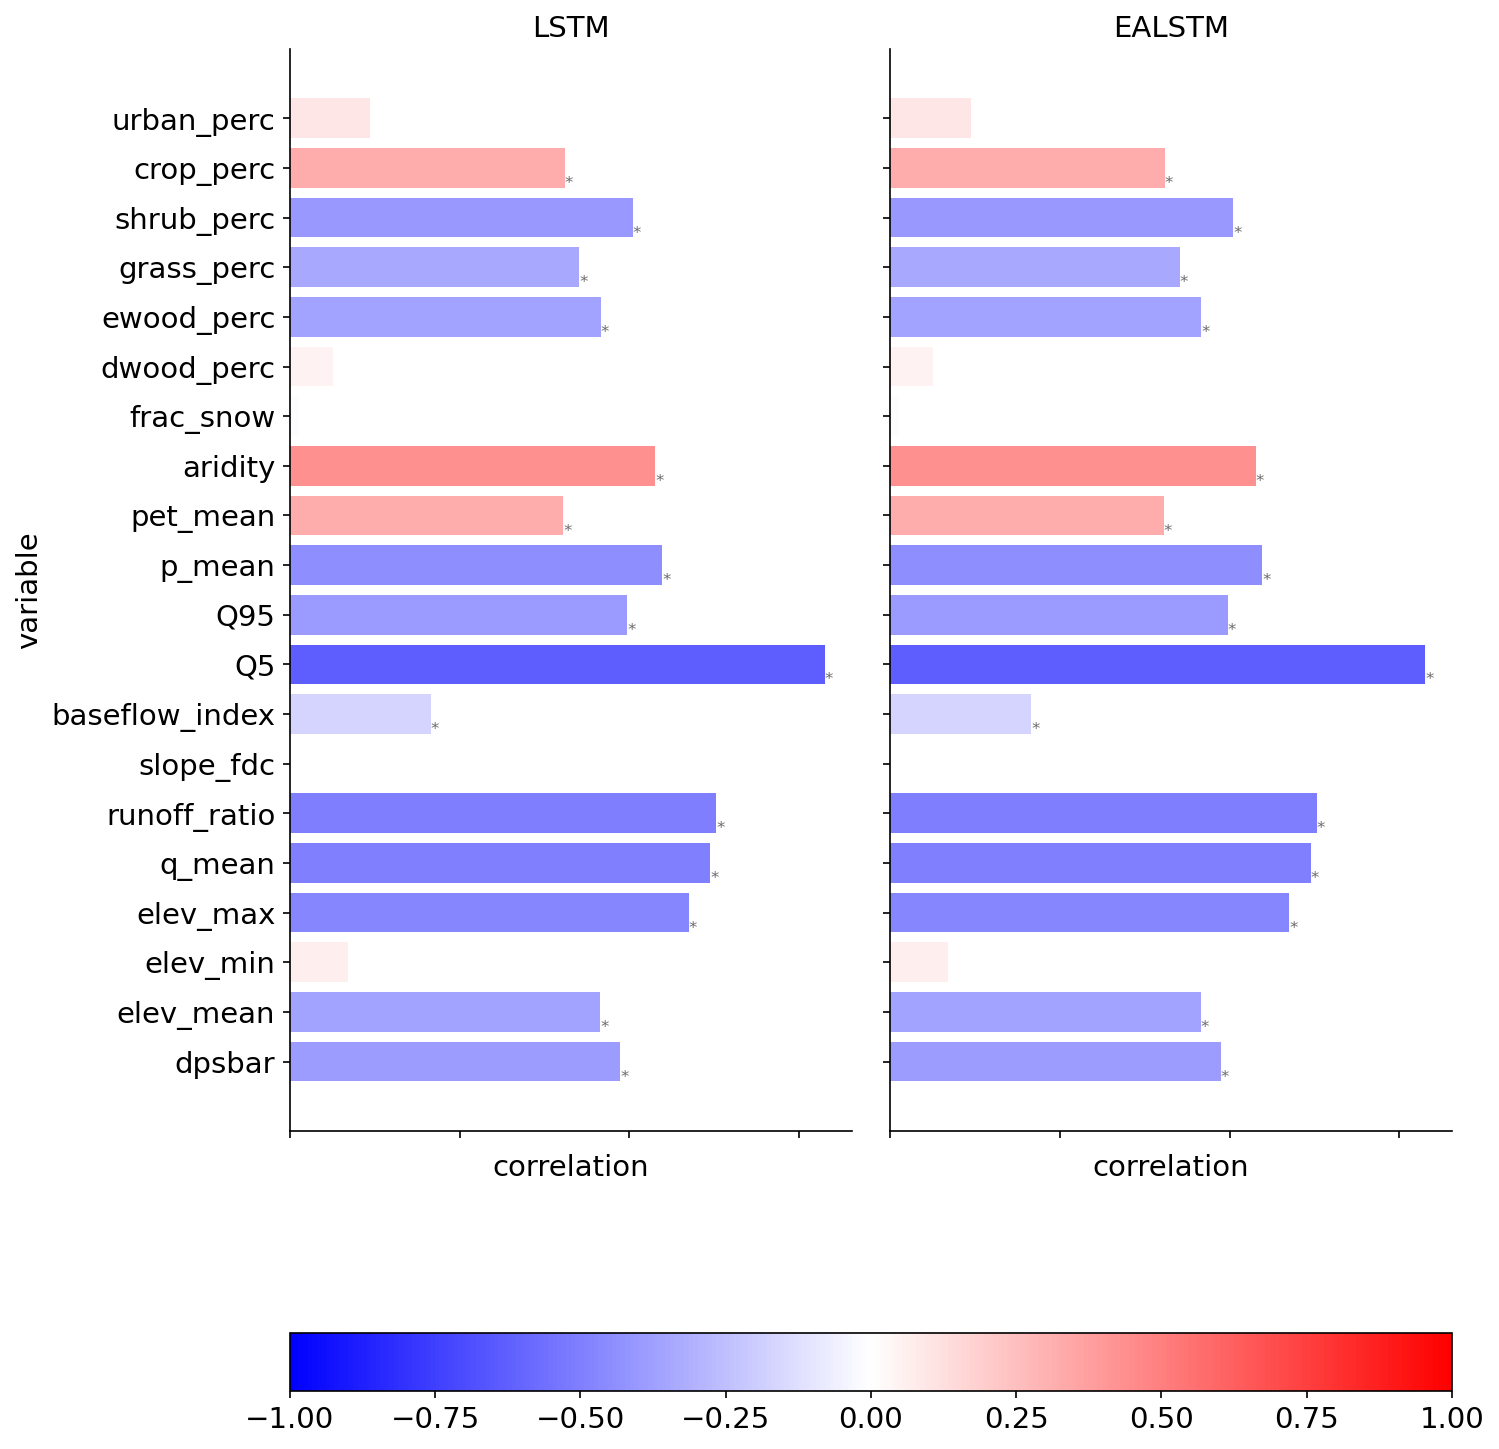

In [38]:
# https://stackoverflow.com/questions/65749781/create-a-table-of-multiple-mini-barplots-in-python/65750091#65750091

from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable


def assign_to_significant_bars(significant: pd.Series):
    ax = plt.gca()
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    significant = significant.to_list()
    list_of_patches = [i for ix, i in enumerate(ax.patches) if significant[ix]]
    for i in list_of_patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_width(), i.get_y(), "*", fontsize=8, color='dimgrey')


# f, ax = plt.subplots(figsize=(12, 8))
norm = TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)
cmap = plt.get_cmap('bwr')

def my_bar_plot(x, y, significant, **kwargs):
    plt.barh(y=y, width=abs(x), color=cmap(norm(x)))
    assign_to_significant_bars(significant)
    ax = plt.gca()
    ax.set_xticklabels([""])

g = sns.FacetGrid(data=corr_df, col='model', height=5, aspect=0.5, sharex=True, sharey=True, size=10)
g.map(my_bar_plot, 'correlation', 'variable', "significant")
g.set_titles(col_template="{col_name}")
g.fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', ax=g.axes, fraction=0.05);

# how does variable X change 

In [39]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, n_bins):
    c_xy = np.histogram2d(x, y, n_bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# mutual information

In [40]:
# all_metrics[metric]

In [41]:
mn_ = all_metrics[metric][[c for c in all_metrics[metric].columns if "ensemble" in c]].mean(axis=1).rename("mean")
std_ = all_metrics[metric][[c for c in all_metrics[metric].columns if "ensemble" in c]].std(axis=1).rename("std")

out = defaultdict(list)
for feat in important_features:
    static[feat]
    _df = static[feat].to_dataframe().join(mn_).join(std_).dropna()
    out["mean"].append(calc_MI(_df[feat], _df["mean"], n_bins=3))
    out["std"].append(calc_MI(_df[feat], _df["std"], n_bins=3))
    out["feature"].append(feat)
    
mi = pd.DataFrame(out)

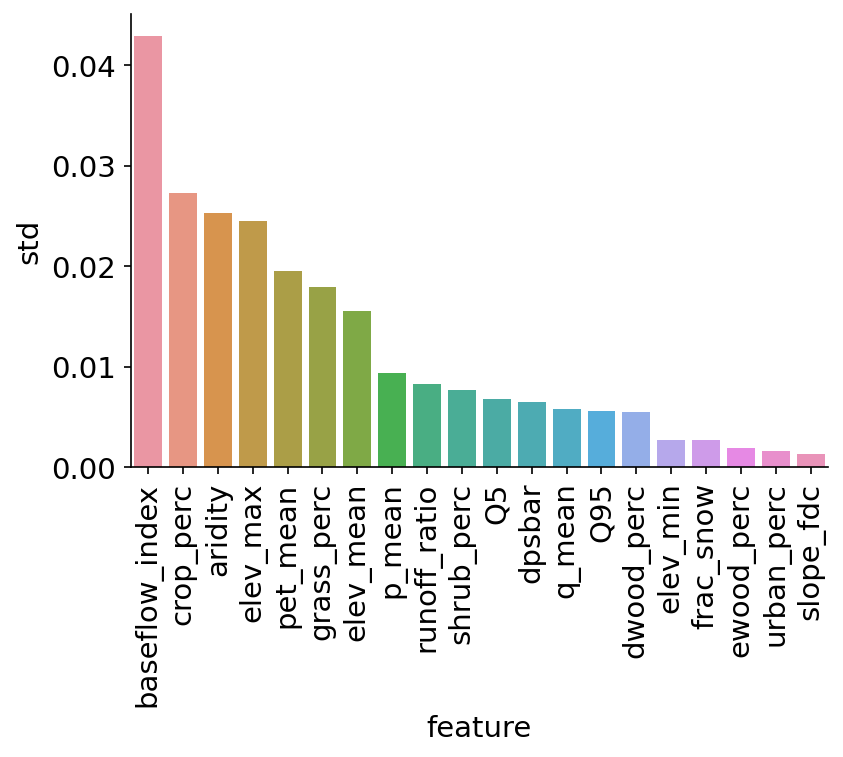

In [42]:
var_ = "std"

sns.barplot(x="feature", y=var_, data=mi.sort_values(var_, ascending=False))
plt.xticks(rotation=90)
sns.despine()

# When do we see more uncertainty?

In [43]:
Q = ds["discharge_spec"].sel(
    time=slice("1998", "2008"), 
    station_id=ensemble_preds.station_id
)
high_q = Q.where(Q > Q.quantile(q=0.9, dim="time"))
med_q = Q.where((Q > Q.quantile(q=0.3, dim="time")) | (Q <= Q.quantile(q=0.7, dim="time")))
low_q = Q.where(Q < Q.quantile(q=0.1, dim="time"))

# med_q

In [44]:
ens_p = ensemble_preds.drop(["obs", "mean"]).to_array().rename({"variable": "member"}).to_dataset(name="sim")
hi_ens = ens_p.where(~high_q.isnull())
med_ens = ens_p.where(~med_q.isnull())
lo_ens = ens_p.where(~low_q.isnull())

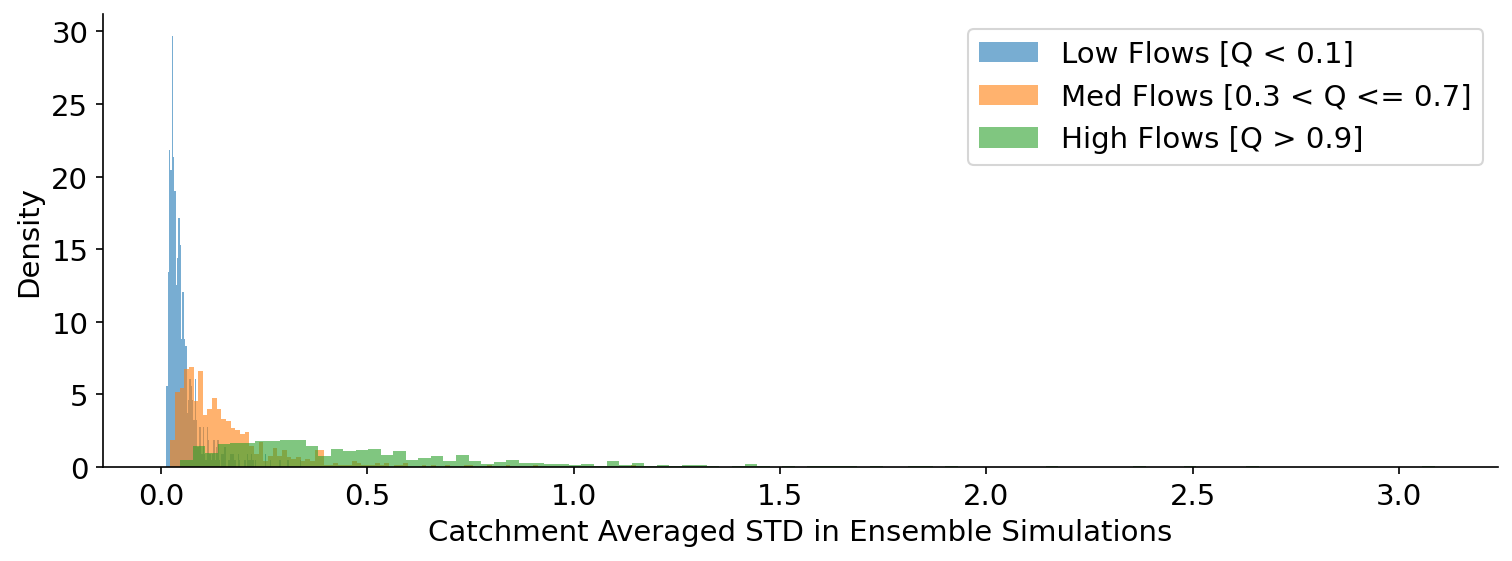

In [45]:
f, ax = plt.subplots(figsize=(12, 4))
ax.hist(lo_ens.std(dim=["member"]).mean(dim="time")["sim"].values, label="Low Flows [Q < 0.1]", alpha=0.6, density=True, bins=100)
ax.hist(med_ens.std(dim=["member"]).mean(dim="time")["sim"].values, label="Med Flows [0.3 < Q <= 0.7]", alpha=0.6, density=True, bins=100)
ax.hist(hi_ens.std(dim=["member"]).mean(dim="time")["sim"].values, label="High Flows [Q > 0.9]", alpha=0.6, density=True, bins=100)
ax.set_xlabel("Catchment Averaged STD in Ensemble Simulations")
ax.set_ylabel("Density")
ax.legend()
sns.despine()

In [46]:
# hist, edges = np.histogram(Q, bins=10)
# Q.to_dataset().groupby_bins("discharge_spec", bins=10)

### Uncertainty

In [47]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [48]:
mean_uncert = ens_p.std(dim="member").mean(dim="time").rename({"sim": "ensemble_std"})
_uncert = mean_uncert["ensemble_std"].to_dataframe()
gdf_uncert = gpd.GeoDataFrame(_uncert.join(points))

In [49]:
mean_q = ensemble_preds["obs"].mean(dim="time")
# normalised ensemble std
gdf_uncert["ensemble_std_norm"] = gdf_uncert["ensemble_std"] / mean_q

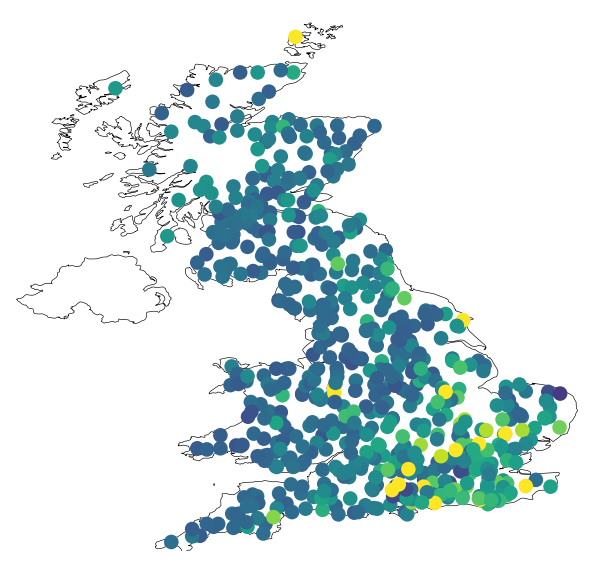

In [50]:
ax = initialise_gb_spatial_plot()
# gdf_uncert.plot("ensemble_std_norm", ax=ax, vmin=0, vmax=0.2, legend=True);
gdf_uncert.plot("ensemble_std_norm", ax=ax, vmin=0, vmax=0.2);

## run correlations on (normalised) catchment average ensemble std

In [51]:
ds_uncert = mean_uncert["ensemble_std"].to_dataset()
ds_uncert["ensemble_std_norm"] = mean_uncert["ensemble_std"] / mean_q

# How many parameters in the models?

In [52]:
%autoreload 2
cfg_paths = sorted(list(run_dir.glob("**/config.yml")))
weight_paths = sorted(list(run_dir.glob("**/model*30.pt")))
run_dirs = sorted([f for f in run_dir.glob("*") if f.is_dir()])

In [53]:
from neuralhydrology.utils.config import Config
from neuralhydrology.modelzoo import get_model
import torch

def load_all_models(ens_dir: Path) -> Dict[str, torch.nn.Module]:
    cfg_paths = sorted(list(ens_dir.glob("*/config.yml")))
    weight_paths = sorted(list(ens_dir.glob("**/model*30.pt")))
    run_dirs = sorted([f for f in ens_dir.glob("*") if f.is_dir()])

    models = {}
    for ix, expt in enumerate([d.name for d in run_dirs]):
        ens_number = f"ens{int(expt.split('ensemble')[-1].split('_')[0])}"
        cfg = Config(cfg_paths[ix])
        model = get_model(cfg)
        model.load_state_dict(torch.load(weight_paths[ix], map_location="cpu"))
        models[ens_number] = model
        
    return models

# load models
models = load_all_models(run_dir)
ealstm_models = load_all_models(ealstm_run_dir)

In [54]:
def count_parameters(model):
    return sum(np.product(p.shape) for p in model.parameters() if p.requires_grad)


print([count_parameters(m) for m in models.values()])
print([count_parameters(m) for m in ealstm_models.values()])

# f, ax = plt.subplots(figsize=(12, 8))
# sns.barplot(x, y, color="C0")
# show_values_on_bars(ax)
# plt.yscale("log")
# ax.set_xlabel("Hidden Size")
# ax.set_ylabel("N Parameters (log)")
# ax.axhline(5500, label="Mean Conceptual Parameters", ls="--", color="grey")
# plt.legend()

# sns.despine()

[23361, 23361, 23361, 23361, 23361, 23361, 23361, 23361]
[14593, 14593, 14593, 14593, 14593, 14593, 14593, 14593]
